<a href="https://colab.research.google.com/github/A-Jouini/predict-SP-500-with-historical-data/blob/main/predict_tomorrow's_S%26P_500_index_price_using_historical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period="max")

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-02-13 00:00:00-05:00,6834.270020,6881.959961,6794.549805,6836.169922,5718360000,0.0,0.0
2026-02-17 00:00:00-05:00,6819.859863,6866.990234,6775.500000,6843.220215,5418480000,0.0,0.0
2026-02-18 00:00:00-05:00,6855.479980,6909.120117,6849.660156,6881.310059,5098160000,0.0,0.0


<Axes: xlabel='Date'>

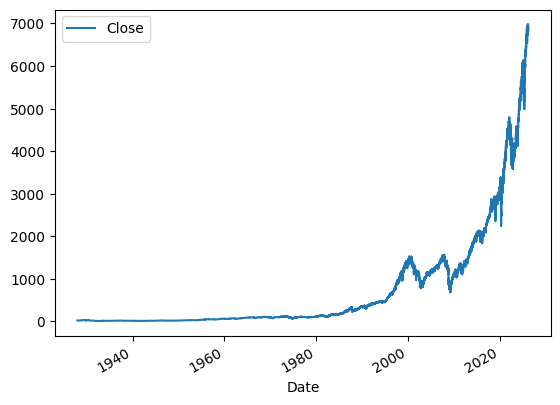

In [5]:
sp500.plot.line(y="Close", use_index =True)

In [6]:
del sp500['Dividends']
del sp500['Stock Splits']

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [9]:
sp500 = sp500.loc["1990-01-01":].copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [12]:
train = sp500.iloc[:-100]

In [13]:
test = sp500.iloc[-100:]

In [14]:
predictors = ["Close","Volume","Open","High","Low"]

In [ ]:
model.fit(train[predictors],train["Target"])

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
preds = model.predict(test[predictors])

In [ ]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

In [ ]:
precision_score(test["Target"],preds)

In [ ]:
combined =pd.concat([test["Target"],preds],axis=1)

In [ ]:
combined.plot()

**BackTesting**

In [ ]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [ ]:
def backtest(data,model,predictors,start=2500,step=250):
  all_predictions = []

  for i in range(start,data.shape[0],step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train,test,predictors,model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500,model,predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

**Additional Predictors**

In [ ]:
horizons = [2,5,60,250,100]

In [ ]:
new_predictors = []
for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()
  ration_column = f"Close_Ratio_{horizon}"
  sp500[ration_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ration_column,trend_column]

In [ ]:
sp500.isna().sum()

In [ ]:
sp500=sp500.dropna()

**Improving the Model**

In [ ]:
model = RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)

In [ ]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >=.6] = 1
  preds[preds <.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [ ]:
predictions = backtest(sp500,model,new_predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

# Predicting Next-Day S&P 500 Direction (with Proper Backtesting)

This notebook builds a *baseline* next-day direction model for the S&P 500 using historical data, then evaluates it with a simple walk-forward backtest.

**Economic hypothesis (simple):** short-horizon momentum/mean-reversion effects and recent trend summaries may contain weak—but measurable—information about next-day direction.

In [ ]:
import yfinance as yf

In [ ]:
sp500 = yf.Ticker("^GSPC")

In [ ]:
sp500 = sp500.history(period="max")

In [ ]:
sp500

In [ ]:
sp500.plot.line(y="Close", use_index =True)

In [ ]:
del sp500['Dividends']
del sp500['Stock Splits']

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
sp500 = sp500.loc["1990-01-01":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
train = sp500.iloc[:-100]

In [ ]:
test = sp500.iloc[-100:]

In [ ]:
predictors = ["Close","Volume","Open","High","Low"]

In [ ]:
model.fit(train[predictors],train["Target"])

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
preds = model.predict(test[predictors])

In [ ]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

In [ ]:
precision_score(test["Target"],preds)

In [ ]:
combined =pd.concat([test["Target"],preds],axis=1)

In [ ]:
combined.plot()

**BackTesting**

In [ ]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [ ]:
def backtest(data,model,predictors,start=2500,step=250):
  all_predictions = []

  for i in range(start,data.shape[0],step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train,test,predictors,model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500,model,predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

**Additional Predictors**

In [ ]:
horizons = [2,5,60,250,100]

In [ ]:
new_predictors = []
for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()
  ration_column = f"Close_Ratio_{horizon}"
  sp500[ration_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ration_column,trend_column]

In [ ]:
sp500.isna().sum()

In [ ]:
sp500=sp500.dropna()

**Improving the Model**

In [ ]:
model = RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)

In [ ]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >=.6] = 1
  preds[preds <.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [ ]:
predictions = backtest(sp500,model,new_predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

## Quick Baselines (sanity checks)

Before trusting a model, compare it to naïve rules that often do surprisingly well on index direction:
- **Always Up**
- **Yesterday’s direction persists**
- **Simple logistic regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Use the same feature set as the final model
X = sp500[new_predictors]
y = sp500["Target"]

# Time-based split (last 20% as test)
split = int(len(sp500) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Baseline 1: always predict Up (1)
always_up = pd.Series(1, index=y_test.index)
always_up_acc = accuracy_score(y_test, always_up)

# Baseline 2: persist yesterday's direction (shifted target)
yesterday = sp500["Target"].shift(1).reindex(y_test.index).fillna(1)
yesterday_acc = accuracy_score(y_test, yesterday)

# Baseline 3: logistic regression (simple, interpretable)
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
lr_preds = pd.Series(lr.predict(X_test), index=y_test.index)
lr_acc = accuracy_score(y_test, lr_preds)

pd.DataFrame(
    {
        "Accuracy": [always_up_acc, yesterday_acc, lr_acc],
    },
    index=["Always Up", "Yesterday Persists", "Logistic Regression"],
)

## From Predictions to a Simple Strategy (with costs)

A direction model is only meaningful if you translate it into returns and **penalize turnover** with a small transaction-cost assumption.

In [ ]:
# Daily returns (close-to-close)
sp500["Ret"] = sp500["Close"].pct_change()

# Use backtest predictions (already walk-forward). Convert to a long/flat signal.
signal = predictions["Predictions"].astype(int)

# Trade on next day (shift signal by 1 to avoid look-ahead)
strategy_ret = signal.shift(1) * sp500["Ret"].reindex(signal.index)

# Simple transaction cost: charge 5 bps (0.0005) each time the signal changes
cost_bps = 0.0005
turnover = signal.diff().abs().fillna(0)  # 1 when switching 0<->1
strategy_ret_net = strategy_ret - turnover * cost_bps

equity = (1 + strategy_ret.fillna(0)).cumprod()
equity_net = (1 + strategy_ret_net.fillna(0)).cumprod()
buy_hold = (1 + sp500["Ret"].reindex(signal.index).fillna(0)).cumprod()

pd.DataFrame(
    {"Buy&Hold": buy_hold, "Strategy (gross)": equity, "Strategy (net)": equity_net}
).plot(title="Cumulative Performance (illustrative)")

## Feature Importance (rough stability check)

Because the backtest re-fits the model each window, this is a *snapshot* importance estimate from fitting once on the full dataset.

In [ ]:
# Fit once on all data to get a rough importance snapshot
model.fit(sp500[new_predictors], sp500["Target"])
imp = pd.Series(model.feature_importances_, index=new_predictors).sort_values(ascending=False)
imp.head(12)

## Overfitting / Regime Sensitivity Check (train vs. test gap)

If performance is much better in-sample than out-of-sample, the signal is likely unstable.

In [ ]:
from sklearn.metrics import precision_score

# Fit final RF on train, evaluate on both
model.fit(X_train, y_train)
train_preds = pd.Series(model.predict(X_train), index=y_train.index)
test_preds = pd.Series(model.predict(X_test), index=y_test.index)

pd.DataFrame(
    {
        "Precision": [precision_score(y_train, train_preds), precision_score(y_test, test_preds)],
        "Accuracy": [accuracy_score(y_train, train_preds), accuracy_score(y_test, test_preds)],
    },
    index=["Train", "Test"],
)